
# Titanic — Estadística

*Qué nos dicen los datos* sobre lo ocurrido: ¿quién sobrevivió más?, ¿importó el sexo, la clase social o la edad?, ¿cómo se ven las distribuciones?, ¿hay sesgo?, ¿son normales?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

pd.set_option("display.max_columns", 200)

In [ ]:
# Cargar datos
df = pd.read_csv("Titanic-Dataset.csv")
print("Forma:", df.shape)
display(df.head())

# Nulos por columna (primera instancia)
print("\nNulos por columna:")
print(df.isna().sum())

Forma: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Nulos por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


Hay valores nulos principalmente en `Age`, `Cabin` y algunos en `Embarked`. También sabemos que `PassengerId` es un identificador y no aporta información estadística.


La idea sería:
1. **Eliminar `PassengerId`** (no es una variable analítica).
2. **Imputar `Embarked`** con la **moda**.
3. **Imputar `Age`** por **mediana** condicionada por `Sex` y `Pclass` (para edades comparables).
4. **Simplificar `Cabin`** a un indicador binario `Cabin_has` (1 si hay cabina registrada, 0 si no).
5. **Crear variables auxiliares**:
   - `family_size = SibSp + Parch + 1` (tamaño de grupo familiar).
   - `is_female` (1 si mujer).
   - `is_child` (1 si edad < 12).
   - `Fare_log = log(1 + Fare)` para comparar distribuciones con sesgo fuerte.


In [17]:
df_limpio = df.copy()

# Eliminar PassengerId 
if "PassengerId" in df_limpio.columns:
    df_limpio.drop(columns=["PassengerId"], inplace=True)

# Embarked: imputar con la moda
if "Embarked" in df_limpio.columns:
    moda_emb = df_limpio["Embarked"].mode().iloc[0]
    df_limpio["Embarked"] = df_limpio["Embarked"].fillna(moda_emb)

# Imputación de Age por grupos (Sex, Pclass) con la mediana del grupo
if "Age" in df_limpio.columns:
    df_limpio["Age"] = df_limpio.groupby(["Sex","Pclass"])["Age"].transform(lambda s: s.fillna(s.median()))

# Cabin a indicador binario
if "Cabin" in df_limpio.columns:
    df_limpio["Cabin_has"] = df_limpio["Cabin"].notna().astype(int)
    df_limpio.drop(columns=["Cabin"], inplace=True)

# Nuevas variables
df_limpio["family_size"] = df_limpio["SibSp"] + df_limpio["Parch"] + 1
df_limpio["is_female"] = (df_limpio["Sex"] == "female").astype(int)
df_limpio["is_child"] = (df_limpio["Age"] < 12).astype(int)
df_limpio["Fare_log"] = np.log1p(df_limpio["Fare"])

# Validación de nulos después
print("Nulos por columna (después de limpiar):")
print(df_limpio.isna().sum())
display(df_limpio.head())

Nulos por columna (después de limpiar):
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Cabin_has      0
family_size    0
is_female      0
is_child       0
Fare_log       0
dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_has,family_size,is_female,is_child,Fare_log
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,2,0,0,2.110213
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,2,1,0,4.280593
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,1,1,0,2.188856
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,2,1,0,3.990834
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1,0,0,2.202765


In [18]:
columnas_numericas = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
columnas_categoricas = df_limpio.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numéricas:", columnas_numericas)
print("Categóricas:", columnas_categoricas)

Numéricas: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_has', 'family_size', 'is_female', 'is_child', 'Fare_log']
Categóricas: ['Name', 'Sex', 'Ticket', 'Embarked']


In [19]:
# Tasa de supervivencia global
tasa_superv = df_limpio["Survived"].mean()
print(f"Tasa global de supervivencia: {tasa_superv:.3f} ({tasa_superv*100:.1f}%)")

# Por sexo
surv_sexo = df_limpio.groupby("Sex")["Survived"].mean().sort_values(ascending=False)
print("\nTasa de supervivencia por sexo:")
print((surv_sexo*100).round(1).astype(str) + "%")

# Por clase
surv_clase = df_limpio.groupby("Pclass")["Survived"].mean().sort_index()
print("\nTasa de supervivencia por clase:")
print((surv_clase*100).round(1).astype(str) + "%")

# Sexo x Clase
sex_clase = df_limpio.pivot_table(index="Sex", columns="Pclass", values="Survived", aggfunc="mean")
print("\nTasa de supervivencia de sexo x clase:")
display((sex_clase*100).round(1))

Tasa global de supervivencia: 0.384 (38.4%)

Tasa de supervivencia por sexo:
Sex
female    74.2%
male      18.9%
Name: Survived, dtype: object

Tasa de supervivencia por clase:
Pclass
1    63.0%
2    47.3%
3    24.2%
Name: Survived, dtype: object

Tasa de supervivencia de sexo x clase:


Pclass,1,2,3
Sex,,,
female,96.8,92.1,50.0
male,36.9,15.7,13.5


Las tasas confirman la regla de “**women and children first**” y el efecto de la **clase social**: las mujeres y los pasajeros de primera clase tuvieron mayor probabilidad de sobrevivir, incluso las mujeres de segunda y tercera clase a comparación de los hombres, espcialmente los de tercera clase.


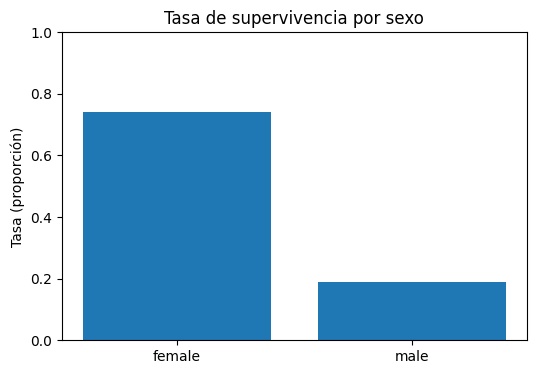

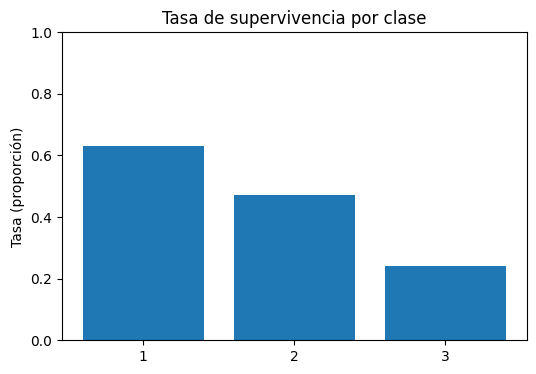

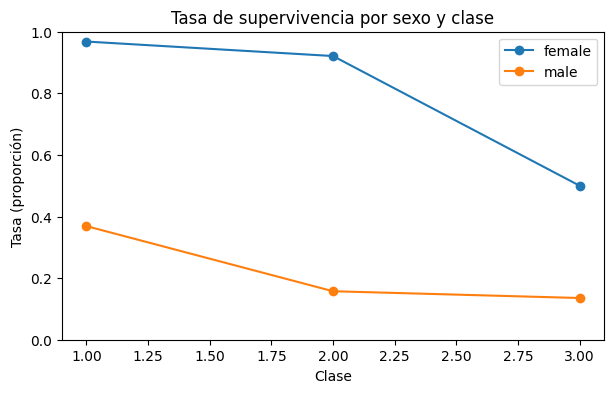

In [20]:
#Gráficos
# Supervivencia por sexo
vals = surv_sexo.values
labs = surv_sexo.index.astype(str).tolist()
plt.figure(figsize=(6,4))
plt.bar(labs, vals)
plt.title("Tasa de supervivencia por sexo")
plt.ylabel("Tasa (proporción)")
plt.ylim(0,1)
plt.show()

# Supervivencia por clase
vals = surv_clase.values
labs = surv_clase.index.astype(str).tolist()
plt.figure(figsize=(6,4))
plt.bar(labs, vals)
plt.title("Tasa de supervivencia por clase")
plt.ylabel("Tasa (proporción)")
plt.ylim(0,1)
plt.show()

# Sexo - Clase
plt.figure(figsize=(7,4))
for i, sex in enumerate(sex_clase.index):
    plt.plot(sex_clase.columns, sex_clase.loc[sex].values, marker='o', label=sex)
plt.title("Tasa de supervivencia por sexo y clase")
plt.xlabel("Clase"); plt.ylabel("Tasa (proporción)"); plt.ylim(0,1)
plt.legend()
plt.show()


La diferencia entre sexos es marcada: mujeres arriba del 90% clase 1 y 2 vs hombres inferior al 40% incluso en la primera clase. El cruce sexo–clase muestra que **ser mujer de primera clase** fue la condición más favorable, y **ser hombre de 3ª** la más desfavorable.


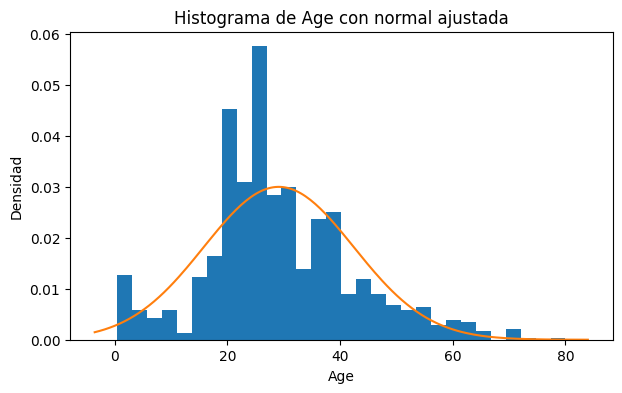

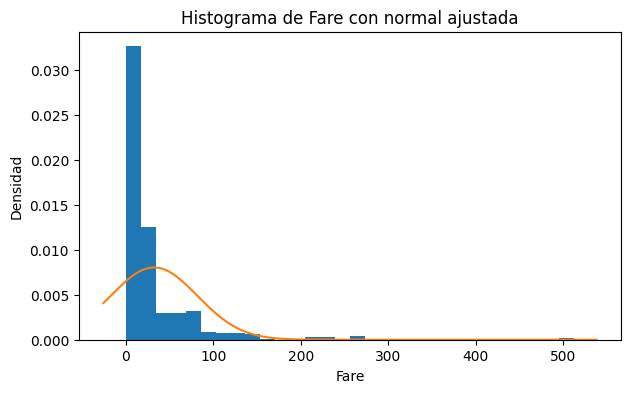

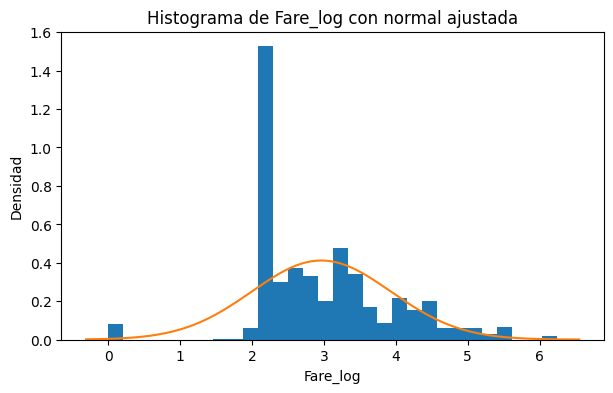

In [21]:
def hist_normal(x, titulo, xlabel):
    x = pd.to_numeric(x, errors='coerce').dropna()
    plt.figure(figsize=(7,4))
    # Histograma con densidad
    plt.hist(x, bins=30, density=True)
    # Curva normal ajustada (misma media y std)
    mu, sigma = x.mean(), x.std()
    xmin, xmax = plt.xlim()
    grid = np.linspace(xmin, xmax, 200)
    plt.plot(grid, norm.pdf(grid, mu, sigma))
    plt.title(titulo); plt.xlabel(xlabel); plt.ylabel("Densidad")
    plt.show()

# Histogramas
hist_normal(df_limpio["Age"], "Histograma de Age con normal ajustada", "Age")
hist_normal(df_limpio["Fare"], "Histograma de Fare con normal ajustada", "Fare")
hist_normal(df_limpio["Fare_log"], "Histograma de Fare_log con normal ajustada", "Fare_log")

`Age` suele aproximarse más a una distribución simétrica (aunque no perfecta). `Fare` es fuertemente asimétrica (cola derecha); sin embargo, al tomar `log(1+Fare)`, la forma se acerca mucho más a una distribución normal, lo que facilita comparaciones.


/var/folders/hq/l8_6hq6j0nn5wyr712wt0kkh0000gn/T/ipykernel_18409/617139989.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in grupos], showfliers=True)


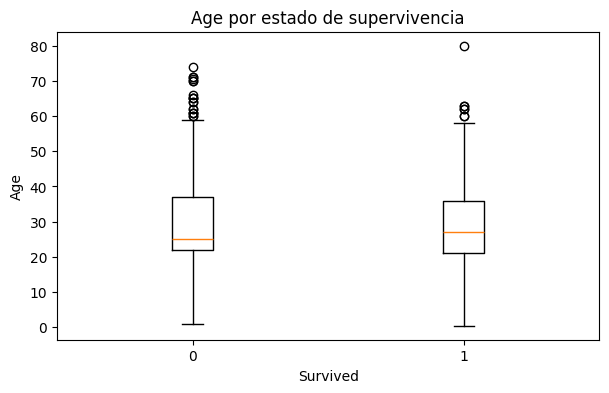

/var/folders/hq/l8_6hq6j0nn5wyr712wt0kkh0000gn/T/ipykernel_18409/617139989.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in grupos], showfliers=True)


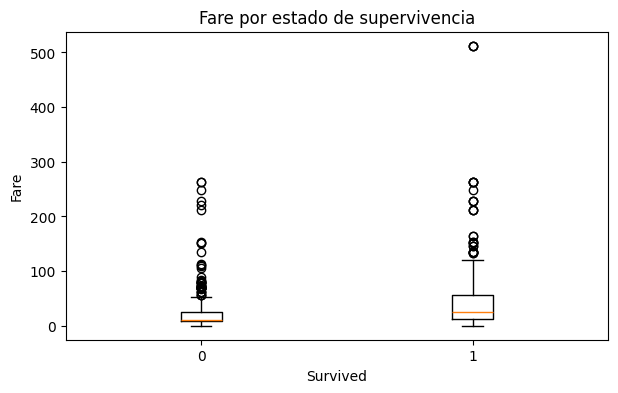

/var/folders/hq/l8_6hq6j0nn5wyr712wt0kkh0000gn/T/ipykernel_18409/617139989.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in grupos], showfliers=True)


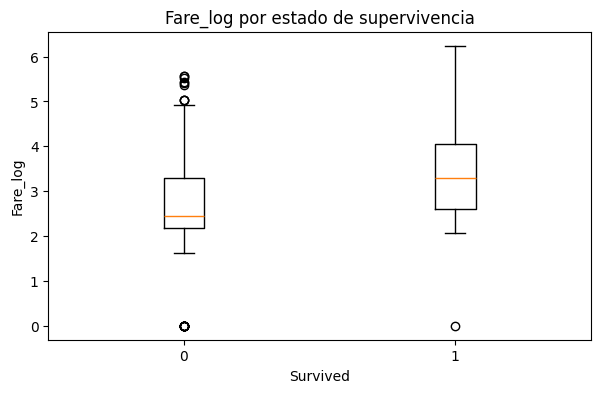

In [22]:
# Boxplots con matplotlib por grupos (0 = no sobrevivió, 1 = sí)
def boxplot_por_grupo(x, g, titulo, ylabel):
    grupos = sorted(g.unique())
    data = [x[g==k] for k in grupos]
    plt.figure(figsize=(7,4))
    plt.boxplot(data, labels=[str(k) for k in grupos], showfliers=True)
    plt.title(titulo); plt.xlabel("Survived"); plt.ylabel(ylabel)
    plt.show()

boxplot_por_grupo(df_limpio["Age"], df_limpio["Survived"], "Age por estado de supervivencia", "Age")
boxplot_por_grupo(df_limpio["Fare"], df_limpio["Survived"], "Fare por estado de supervivencia", "Fare")
boxplot_por_grupo(df_limpio["Fare_log"], df_limpio["Survived"], "Fare_log por estado de supervivencia", "Fare_log")

Los sobrevivientes tienden a mostrar edades menores, mayor proporción de mujeres y niños y tarifas más altas, coherente con la prioridad dada a mujeres/niños y con el acceso/ubicación a botes salvavidas de pasajeros de mayor clase social.


In [25]:
# Tasas por (sexo x clase) ya calculadas arriba pero añadimos niños
tasa_niños = df_limpio.groupby("is_child")["Survived"].mean().rename({0:"No niño", 1:"Niño"})
print("Tasa de supervivencia — niños vs no niños:")
print((tasa_niños*100).round(1).astype(str) + "%")


# Crear variable niño si no existe
df_limpio["is_child"] = (df_limpio["Age"] < 12).astype(int)
# Tabla de supervivencia: niños vs clase
child_class = df_limpio[df_limpio["is_child"] == 1].groupby("Pclass")["Survived"].mean()
print("\nTasa de supervivencia de niños por clase:")
print((child_class * 100).round(1).astype(str) + "%")


Tasa de supervivencia — niños vs no niños:
is_child
No niño    36.8%
Niño       57.4%
Name: Survived, dtype: object

Tasa de supervivencia de niños por clase:
Pclass
1     75.0%
2    100.0%
3     40.4%
Name: Survived, dtype: object


En principio, aunque los niños presentan más probabilidad que los adultos, lo cual tiene sentido, pues, fueron priorizados; no tiene sentido que la segunda clase tenga más porcentaje que la primera. Esto se debe deber a algo en los datos. Veamos

In [26]:
# Conteo de niños por clase
conteo_niños = df_limpio[df_limpio["is_child"] == 1]["Pclass"].value_counts().sort_index()
print("Número total de niños por clase:")
print(conteo_niños)

Número total de niños por clase:
Pclass
1     4
2    17
3    47
Name: count, dtype: int64


La clase social seguía marcando la diferencia: en primera y segunda clase la gran mayoría de los niños se salvaron, mientras que en tercera más de la mitad murieron. El 100% de segunda clase es real en los datos, pero debe entenderse con cuidado: es un grupo pequeño y coincidió que todos sobrevivieron.

In [30]:
vars_corr = ["Survived","Age","Fare","Fare_log","SibSp","Parch","family_size","Cabin_has"]
corr = df_limpio[vars_corr].corr(method="pearson")
corr

,Survived,Age,Fare,Fare_log,SibSp,Parch,family_size,Cabin_has
Survived,1.000000,-0.059579,0.257307,0.329862,-0.035322,0.081629,0.016639,0.316912
Age,-0.059579,1.000000,0.122692,0.142061,-0.249854,-0.175526,-0.258456,0.277022
Fare,0.257307,0.122692,1.000000,0.787543,0.159651,0.216225,0.217138,0.482075
Fare_log,0.329862,0.142061,0.787543,1.000000,0.318528,0.332186,0.383658,0.557192
SibSp,-0.035322,-0.249854,0.159651,0.318528,1.000000,0.414838,0.890712,-0.040460
Parch,0.081629,-0.175526,0.216225,0.332186,0.414838,1.000000,0.783111,0.036987
family_size,0.016639,-0.258456,0.217138,0.383658,0.890712,0.783111,1.000000,-0.009175
Cabin_has,0.316912,0.277022,0.482075,0.557192,-0.040460,0.036987,-0.009175,1.000000


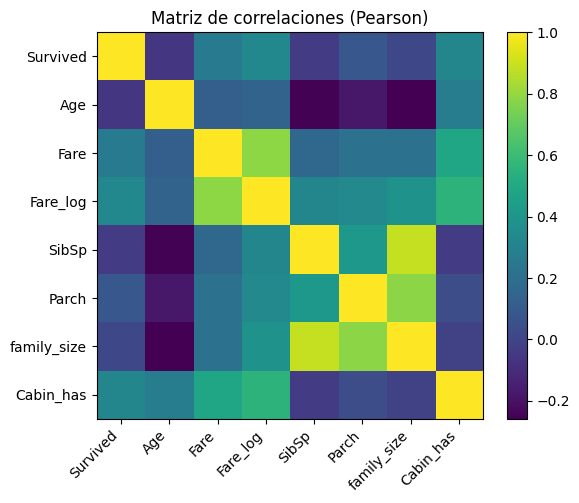

In [31]:
# Mapa simple de correlación con matplotlib
fig, ax = plt.subplots(figsize=(6,5))
cax = ax.imshow(corr, interpolation="nearest")
ax.set_xticks(range(len(corr.columns))); ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index))); ax.set_yticklabels(corr.index)
fig.colorbar(cax)
ax.set_title("Matriz de correlaciones (Pearson)")
plt.tight_layout()
plt.show()

La correlación lineal simple sugiere que `Fare` (y sobre todo `Fare_log`) se relacionan positivamente con `Survived`, esto es: pasajes más caros → mayor probabilidad de supervivencia. `Age` suele mostrar una relación débil o ligeramente negativa. `family_size` puede penalizar la supervivencia cuando es muy grande (dificultad logística). Estas correlaciones no implican causalidad, pero apoyan la lectura cualitativa.


In [32]:
from collections import Counter
from statistics import harmonic_mean, geometric_mean

def moda(serie: pd.Series):
    vals = serie.dropna().tolist()
    if not vals:
        return np.nan
    c = Counter(vals)
    maxf = max(c.values())
    modas = [v for v,f in c.items() if f == maxf]
    if maxf == 1:
        return np.nan
    try:
        return min(modas)
    except Exception:
        return modas[0]

def medidas_tendencia(serie: pd.Series):
    s = pd.to_numeric(serie, errors='coerce').dropna()
    if len(s) == 0:
        return {"media":np.nan,"mediana":np.nan,"moda":np.nan,"armonica":np.nan,"geometrica":np.nan}
    media = s.mean()
    mediana = s.median()
    moda_val = moda(s)
    pos = s[s > 0]
    armonica = harmonic_mean(pos) if len(pos)>0 else np.nan
    geometrica = geometric_mean(pos) if len(pos)>0 else np.nan
    return {"media":media,"mediana":mediana,"moda":moda_val,"armonica":armonica,"geometrica":geometrica}

cols_num = df_limpio.select_dtypes(include=[np.number]).columns.tolist()
tend_tbl = {col: medidas_tendencia(df_limpio[col]) for col in cols_num}
tend_df = pd.DataFrame(tend_tbl).T
tend_df

,media,mediana,moda,armonica,geometrica
Survived,0.383838,0.000000,0.000000,1.000000,1.000000
Pclass,2.308642,3.000000,3.000000,1.889046,2.113932
Age,29.112424,26.000000,25.000000,14.821205,24.775430
SibSp,0.523008,0.000000,0.000000,1.205752,1.348155
Parch,0.381594,0.000000,0.000000,1.316169,1.430969
Fare,32.204208,14.454200,8.050000,13.681705,18.980239
Cabin_has,0.228956,0.000000,0.000000,1.000000,1.000000
family_size,1.904602,1.000000,1.000000,1.332800,1.531920
is_female,0.352413,0.000000,0.000000,1.000000,1.000000
is_child,0.076319,0.000000,0.000000,1.000000,1.000000



**Nota:** `Survived` y `Pclass` son discretas; `PassengerId` fue eliminado por irrelevante. La media geométrica/armónica no aplica si hay valores no positivos.


In [34]:
def dispersion(serie: pd.Series):
    s = pd.to_numeric(serie, errors='coerce').dropna()
    if len(s) == 0:
        return {"varianza":np.nan,"desv_estandar":np.nan,"desv_media":np.nan}
    media = s.mean()
    varianza = s.var(ddof=1)
    desv_estandar = s.std(ddof=1)
    desv_media = (s - media).abs().mean()
    return {"varianza":varianza,"desv_estandar":desv_estandar,"desv_media":desv_media}

disp_tbl = {col: dispersion(df_limpio[col]) for col in cols_num}
disp_df = pd.DataFrame(disp_tbl).T
disp_df

,varianza,desv_estandar,desv_media
Survived,0.236772,0.486592,0.473013
Pclass,0.699015,0.836071,0.761968
Age,177.007700,13.304424,10.158284
SibSp,1.216043,1.102743,0.713780
Parch,0.649728,0.806057,0.580742
Fare,2469.436846,49.693429,28.163692
Cabin_has,0.176734,0.420397,0.353071
family_size,2.603248,1.613459,1.090395
is_female,0.228475,0.477990,0.456436
is_child,0.070573,0.265657,0.140988


In [35]:
from scipy.stats import skew

def asimetria(serie: pd.Series):
    s = pd.to_numeric(serie, errors='coerce').dropna()
    if len(s) < 3:
        return {"fisher":np.nan,"pearson":np.nan,"interpretacion":"indeterminado"}
    media = s.mean(); mediana = s.median(); desv = s.std(ddof=1)
    fisher = skew(s, bias=False)
    pearson = (3*(media - mediana)/desv) if desv > 0 else np.nan
    if np.isfinite(fisher):
        if abs(fisher) < 0.5:
            inter = "aprox. simétrica"
        elif fisher > 0:
            inter = "sesgo positivo (cola derecha)"
        else:
            inter = "sesgo negativo (cola izquierda)"
    else:
        inter = "indeterminado"
    return {"fisher":fisher,"pearson":pearson,"interpretacion":inter}

skew_tbl = {col: asimetria(df_limpio[col]) for col in cols_num}
skew_df = pd.DataFrame(skew_tbl).T
skew_df

,fisher,pearson,interpretacion
Survived,0.478523,2.366488,aprox. simétrica
Pclass,-0.630548,-2.480738,sesgo negativo (cola izquierda)
Age,0.534083,0.701817,sesgo positivo (cola derecha)
SibSp,3.695352,1.422836,sesgo positivo (cola derecha)
Parch,2.749117,1.420223,sesgo positivo (cola derecha)
Fare,4.787317,1.071571,sesgo positivo (cola derecha)
Cabin_has,1.292367,1.633857,sesgo positivo (cola derecha)
family_size,2.727441,1.68198,sesgo positivo (cola derecha)
is_female,0.618921,2.211843,sesgo positivo (cola derecha)
is_child,3.196868,0.861851,sesgo positivo (cola derecha)



Los valores altos y positivos en `fisher` para `Fare` (y, en menor medida, `SibSp`, `Parch`) confirman el **sesgo positivo** que vimos: muchas observaciones bajas y una **cola larga a la derecha**. En `Age`, los coeficientes tienden a valores cercanos a cero, coherentes con una forma más simétrica. Estas métricas no se interpretan como normalidad para variables discretas (p. ej., `Survived`, `Pclass`).
